# Support Vector Machine for classification

In this notebook, we describe theoreticala background of Support Vector Machine (SVM) classification, and implement it.

Although some calculations are shown in the textbook, the discussion there (especially the treatment of primal-dual correspondence and the way of obtaining the margin $b$) is insufficient for me. So, I will describe some aspects in detail.

Notes 
* Here we assume finite dimensional feature space. However, note that widely utilized kernels such as Gaussian kernel requires infinite dimensional feature space. Thus, the derivation shown in the notebook (and the textbook) does not apply to SVM with Gaussian kernel. 
* The algorithm implemented here is not intended to be computationally efficient, but to be pedagogical in that it literally implements theoretical formulas. 

In [1]:
import numpy as np
from scipy.optimize import minimize
import matplotlib as mpl
from matplotlib import pyplot as plt
import time

%matplotlib inline
mpl.rc("savefig",dpi=100)

## 1 Theoretical background 

Here we first discuss theoretical background of SVM classifier. 
The notation follows that of the textbook, unless otherwise stated. 

For those who are not interested in theoretical background, please skip the section, and go to Section 2. 

### 1.1 Original minimizatoin problem 

Following the discussion from in the textbook, our task here is to minimize the function 
\begin{equation}
    C \sum_{n=1}^{N} \xi_n + \frac{1}{2} \| w \|^2
\end{equation}
under the constraints
\begin{eqnarray}
    \xi_n \geq 0 , \ \ t_n y_n \geq 1 - \xi_n \ \ (\forall n \in \{ 1, \dots, N \}),
\end{eqnarray}
where $y_n := w^T \phi_n + b$ (Here, $\phi_n$ corresponds to $\phi(x_n)$ in the textbook.).

For later convenience, we will denote
\begin{eqnarray}
    x &:=& (w, b, \xi) \in \mathbb{R}^M \times \mathbb{R} \times \mathbb{R}^N = \mathbb{R}^{N+M+1} \\
    f(x) &:=& C \sum_{n=1}^{N} \xi_n + \frac{1}{2} \| w \|^2 \\
    g_n(x) &:=& t_n (w^T \phi_n + b) - 1 + \xi_n \\
    h_n(x) &:=& \xi_n
\end{eqnarray}
and 
\begin{equation}
    S := \left\{ x \in \mathbb{R}^{N+M+1} \middle | 
        g_n(x) \geq 0, h_n(x) \geq 0 \ (\forall n \in \{1, \dots, M \}) \right\}
\end{equation}

Note that 
* the objective functoin $f$ is a convex function, 
* the functions representing constraints $g_n$ and $h_n$ are affine (and hence convex) functions, and 
* $S$ is a convex set, and has interior points.

We solve this minimization problem by utilizing Lagrangian duality. 

Before considering our specific problem, in the next section we will deal with Lagrangian duality from more general perspectives, and come back to our SVM problem in the following section.

### 1.2 Lagrange duality (general theory)


#### 1.2.1 Lagrangian 

Let us consider a general optimization problem of minimizing $f : \mathbb{R}^n \rightarrow \mathbb{R}$ under the constraints represnted by $g_i : \mathbb{R}^n \rightarrow \mathbb{R}$, $g_i(x) \geq 0$ $(i \in \{ 1, \dots, m \})$. 
For simplicity, we denote by $S$ the region satisfying the constraints.

Inspired by the Lagrange multiplier method, let us define the Lagrangian $L : \mathbb{R}^n \times \mathbb{R}_{+}^{m} \rightarrow \mathbb{R}$ by
\begin{equation}
    L(x,\lambda) = f(x) - \sum_{i=1}^{m} \lambda_i g_i(x), 
\end{equation}
where $\mathbb{R}_{+}$ denotes the set of all non-negative real numbers.

The idea here is to convert the minimization problem with respect to $x$ to a maximization problem with respect to $\lambda$. 

#### 1.2.2 Dual problem

Let us define two functions from the Lagrangian as follows
\begin{eqnarray}
    F(x) &:=& \sup_{\lambda \in \mathbb{R}_{+}^{m}} L(x,\lambda) \\
    q(\lambda) &:=& \inf_{x \in \mathbb{R}^n} L(x, \lambda) . 
\end{eqnarray}
Note that 
\begin{equation}
    F(x) = \sup_{\lambda \in \mathbb{R}_{+}^{m}} L(x,\lambda) =
    \begin{cases}
        f(x) & (\forall i \in \{ 1, \dots, N \} (g_i(x) \geq 0 )) \\
        \infty & (\mbox{otherwise})
    \end{cases}, 
\end{equation}
and thus, we have 
\begin{equation}
    \inf_{x \in \mathbb{R}^n} F(x) = \inf_{x \in S} f(x)
\end{equation}

I follows easily from the definition that  
\begin{eqnarray}
    &{}& \forall x \in \mathbb{R}^n, \forall \lambda \in \mathbb{R}_{+}^{m} \ : \ 
        F(x) \geq L(x,\lambda) \geq q(\lambda) \\
    &{}& \inf_{x \in S} f(x) \geq \sup_{\lambda \in \mathbb{R}_{+}^{m}} q(\lambda)
\end{eqnarray}

Our expectation is that we can get some information about the original problem of minimizing $f$ in $S$ by solving the problem of maximising $q$ in $\mathbb{R}_{+}^{m}$. 
We call the latter problem the Lagrangian dual of the original problem. The original problem is also called the primal problem, in light of the dual problem.  

#### 1.2.3 The relation between primal and dual problems

The expectation stated above is, under some conditions, correct: 
Assume the following conditions 
* $f$ and $g_i$ are all convex functions (Hence, the minimization problem is a convex optimizatoin problem).
* The set $S$ has at least one interior point (Slater's condition).
* $f$ attains its minimum at $x^{\ast} \in S$ and $q$ attains its maximum in $\lambda^{\ast} \in \mathbb{R}_{+}^{m}$. 

Then, it is known that 
\begin{equation}
    f(x^{\ast}) = q(\lambda^{\ast})
\end{equation}
follows (The (strong) duality theorem for convex optimization problem.).

Thus, we can obtain the minimum value of $f$ on $S$ by solving the dual problem. 
Moreover, we can obtain conditions on $x$ which maximizes $f$ on $S$ as follows: 
From inequality shown above and the strong duality theorem, we have
\begin{equation}
    f(x^{\ast}) = L(x^{\ast}, \lambda^{\ast}) = q(\lambda^{\ast}). 
\end{equation}
Hence, 
* The minimizer $x^{\ast}$ must satisfy $L(x^{\ast}, \lambda^{\ast}) = q(\lambda^{\ast})$, and 
* the following inequalities hold:
\begin{equation}
    L(x^{\ast}, \lambda) \geq L(x^{\ast}, \lambda^{\ast}) \geq L(x^{\ast}, \lambda).
\end{equation}

The latter inequalities follow from
\begin{eqnarray}
    &{}& L(x, \lambda^{\ast}) \geq q(\lambda^{\ast}) = L(x^{\ast},\lambda^{\ast}) \\
    &{}& L(x^{\ast}, \lambda) \leq F(x^{\ast}) = L(x^{\ast}, \lambda^{\ast}).
\end{eqnarray}

The famous KKT conditions follow directly from the inequalities, and especially, it follows that
\begin{equation}
    \forall i \in \{ 1, \dots, m\} \ : \ \left( \lambda^{\ast}_i = 0 \mbox{ or } g_i(x^{\ast}) = 0 \right)
\end{equation}

### 1.3 Solving SVM optimizatoin problem by Lagrange duality

#### 1.3.1 Lagrangian and the dual problem

We can directly apply the discussoin in the previous section to our SVM minimization problem. 

First, note that $f$ must has minimum on $S$, because $f$ is continuous and $S$ is a compact set.

Let us define our Lagrangian $L : \mathbb{R}^{N+M+1} \times \mathbb{R}_{+}^{2N} \rightarrow \mathbb{R}$by 
\begin{equation}
    L(x,\lambda) := f(x) - \sum_{n=1}^{N} a_n g_n(x) - \sum_{n=1}^{N} \mu_n h_n(x),
\end{equation}
where $\lambda = (a,\mu)$, and $a,\mu \in \mathbb{R}^{N}$. 

Then, to evaluate $q(\lambda)$, which is obtained by minimizing $L(x,\lambda)$ with respect to $x$, we manipulate collect the terms in $L$ as follows: 
\begin{eqnarray}
    L(x, \lambda)
    &=&  C \sum_{n=1}^{N} \xi_n + \frac{1}{2} \| w \|^2 - \sum_{n=1}^{N} a_n \left[ t_n (w^T \phi_n + b) - 1 + \xi_n \right] - \sum_{n=1}^{N} \mu_n \xi_n \\
    &=& \sum_{n=1}^{N}(C - \mu_n - a_n ) \xi_n 
        + \frac{1}{2} \| w \|^2 - \left( \sum_{n=1}^{N} a_n t_n \phi_n \right)^T w
        - \sum_{n=1}^{N} a_n( b t_n - 1)
\end{eqnarray}
Hence, it can be easily shown that 
\begin{equation}
    q(\lambda) = \inf_{x\in\mathbb{R}^{N+M+1}} L(x,\lambda)
    = \begin{cases}
        \sum_{n=1}^{N} a_n - \frac{1}{2} \sum_{n,m=1}^{N} a_n a_m t_n t_m k(x_n, x_m) 
        & (C - \mu_n - a_n = 0 (\forall n \in \{1,\dots, N \}), \sum_{n=1}^{N} a_n t_n = 0) \\
        -\infty  & (\mbox{otherwise})
    \end{cases},
\end{equation}
where $k(x, x') := \phi(x)^T \phi(x')$. 
Thus, $q$ also has its maximum in $\mathbb{R}_{+}^{2N}$.

Based on properties shown so far, it can be seen that the strong duality theorem stated in the previous section can be applied to our problem; 
\begin{equation}
    \min_{x \in S} f(x) = \max_{\lambda \in \mathbb{R}_{+}^{2N}} q(\lambda).
\end{equation}

#### 1.3.2 Numerically solving the dual problem

Now, we solve the dual problem.
From the form of $q$, it suffices to minimize $\tilde{q} : \mathbb{R}^N \rightarrow \mathbb{R}$ defined by 
\begin{equation}
    \tilde{q}(a) := \sum_{n=1}^{N} a_n - \frac{1}{2} \sum_{n,m=1}^{N} a_n a_m t_n t_m k(x_n, x_m), 
\end{equation}
on 
\begin{equation}
    S' := \left\{ a \in \mathbb{R}^N \middle| 0 \leq a_n \leq C \ (\forall n = 1, \dots, N), \ 
        \sum_{n=1}^{N} a_n t_n = 0 \right\}. 
\end{equation}
This problem can be easily solved numerically. 
Henceforth, we assume that we have solved the problem, and have the minimizer $\lambda^{\ast}$. 

We define 
\begin{equation}
    \mathcal{S} := \left\{n \in  \mathbb{Z} \middle| 1 \leq n \leq N, \ a_n \neq 0  \right\}, 
\end{equation}
and call $x_n$ such that $n \in \mathcal{S}$ a support vector, 
whose relevance will be clear in the next subsection.



#### 1.3.3 Obtaining the minimizer of the original problem

For our aim of classification, it suffices to obtain $w^{\ast}$ and $b^{\ast}$. 

From the general result in the previous section, $x^{\ast}$ must satisfies 
\begin{equation}
    L(x^{\ast}, \lambda^{\ast}) = q(\lambda^{\ast}). 
\end{equation}
From this condition and definition of the Lagrangian, we have 
\begin{equation}
    w^{\ast} = \sum_{n=1}^{N} a^{\ast}_n t_n \phi_n = \sum_{n \in \mathcal{S}} a^{\ast}_n t_n \phi_n.
\end{equation}
We can see that $x_n$ with $n$ such that $a_n > 0$ does not appear in the final result.

Obtaining $b^{\ast}$ is more tricky.

Note : It is stated in the textbook that we can obtain $b^{\ast}$ from equation (7.36) with $n$ satisfying $0 < a^{\ast}_{n} < C$. However, such $n$ does not always exist. A counter example can be easily constructed in which we have $a^{\ast}_{n} = C$ for all $n$ (e.g. $N=2$, $x_1 = (1,0)^T, x_2 =(0,1)^T$, $t_1=1, t_2 = -1$, $k(x,x')=x^T x'$, $C=1/2$). 

We just cite the result from equtionas (11) and (14) of  
Bottou, Lin "Support Vector Machine Solvers"
https://www.csie.ntu.edu.tw/~cjlin/papers/bottou_lin.pdf ,
which states that $b$ can be an arbitrary value as long as 
\begin{eqnarray}
    b &\geq& \max \left\{ t_n g^{\ast}_{n} \middle| n \in I \right\} \\
    b &\leq& \min \left\{ t_n g^{\ast}_{n} \middle| n \in J \right\} \\
\end{eqnarray}
where
\begin{eqnarray}
    g^{\ast}_{n} &:=& \left. \frac{\partial \tilde{q}}{\partial a_n}\right|_{a=a^{\ast}} 
        = 1 - t_n \sum_{m=1}^{N} a^{\ast}_{m} t_m k(x_n,x_m) \\
    I &:=& \left\{ n \in \mathbb{Z} \middle| 1 \leq n \leq N, \ 
        (t_n=1 \mbox{ and } a^{\ast}_n < C) \mbox{ or } (t_n = -1 \mbox{ and } a^{\ast}_n > 0) \right\} \\
    J &:=& \left\{ n \in \mathbb{Z} \middle| 1 \leq n \leq N, \ 
        (t_n=1 \mbox{ and } a^{\ast}_n > 0) \mbox{ or } (t_n = -1 \mbox{ and } a^{\ast}_n < C) \right\}.
\end{eqnarray}
It was proved in the reference that the max value is smaller than or equal to the min value, and hence such $b$ always exists.

If we have $n$ such that $0 < a_n < C$, then same $n$ appears in $I$ and $J$, which means that $b$ can take only one value, which is consistent with the result in the textbook. 

## 2 From math to code

Here we summarize the theoretical result, which will be translated into the code in the following sections.

* Generate the kernel matrix $k(x_n,x_m) \ (n,m = 1, \dots, N)$ from the input training data $x_1, \dots, x_N$ and a given function $k$.
* Given the constant $C > 0$ and the kernel matrix $k(x_n,x_m) \(n,m = 1, \dots, N)$, maximize the function $\tilde{q} : \mathbb{R}^N \rightarrow \mathbb{R}$ defined by 
\begin{equation}
    \tilde{q}(a) := \sum_{n=1}^{N} a_n - \frac{1}{2} \sum_{n,m=1}^{N} a_n a_m t_n t_m k(x_n, x_m), 
\end{equation}
on 
\begin{equation}
    S' := \left\{ a \in \mathbb{R}^N \middle| 0 \leq a_n \leq C \ (\forall n = 1, \dots, N), \ 
        \sum_{n=1}^{N} a_n t_n = 0 \right\}. 
\end{equation}
The obtained $a$ will be denoted by $a^{\ast}$.
* Calculate the optimal $w$ by 
\begin{equation}
    w^{\ast} = \sum_{n=1}^{N} a^{\ast}_n t_n \phi_n = \sum_{n \in \mathcal{S}} a^{\ast}_n t_n \phi_n.
\end{equation}
* Choose $b$ such that 
\begin{eqnarray}
    \max \left\{ t_n g^{\ast}_{n} \middle| n \in I \right\} 
    \leq b \leq 
    \min \left\{ t_n g^{\ast}_{n} \middle| n \in J \right\} 
\end{eqnarray}
where
\begin{eqnarray}
    g^{\ast}_{n} &:=& \left. \frac{\partial \tilde{q}}{\partial a_n}\right|_{a=a^{\ast}} 
        = 1 - t_n \sum_{m=1}^{N} a^{\ast}_{m} t_m k(x_n,x_m) \\
    I &:=& \left\{ n \in \mathbb{Z} \middle| 1 \leq n \leq N, \ 
        (t_n=1 \mbox{ and } a^{\ast}_n < C) \mbox{ or } (t_n = -1 \mbox{ and } a^{\ast}_n > 0) \right\} \\
    J &:=& \left\{ n \in \mathbb{Z} \middle| 1 \leq n \leq N, \ 
        (t_n=1 \mbox{ and } a^{\ast}_n > 0) \mbox{ or } (t_n = -1 \mbox{ and } a^{\ast}_n < C) \right\}.
\end{eqnarray}
* For a test input $x$, calculate 
\begin{equation}
    y(x) = \langle w^{\ast} , \phi(x) \rangle + b
    = \sum_{n=1}^{N} a_n t_n k(x,x_n) + b
\end{equation}
and predict $t=1$ if $y(x) > 0$, $t=-1$ if $y(x) < 0$.

## 3 Implementation


Here we implement the support vector classifier with Gaussian kernel given by
\begin{equation}
    k(x,x') = \exp \left( -\frac{\|x - x' \|^2}{2s^2} \right)
\end{equation}
where $s>0$ is a hyper parameter.

For the implementation of the function which calculates the kernel matrix, please refer to the notebook discussing Gaussian process regression.

In [2]:
class SVC:
    def __init__(self, C=1.0, kernel="linear",params=None):
        self.C = C
        self.kernel = kernel
        self.params = params

        self.b = None
        self.a = None
        self.Xtrain = None
        self.ttrain = None
        
    # function for calculating kernel matrix    
    def genK(self,A,B):
        if self.kernel == "linear":
            return A @ B.T
        if self.kernel == "gauss":
            s = self.params['s']
            # make sure that A and B are matrices
            if len(np.shape(A)) == 1:
                A = np.reshape(A, (len(A),1))
            if len(np.shape(B)) == 1:
                B = np.reshape(B, (len(B),1))
            tmp = np.reshape(np.sum(A**2,axis=1),(len(A),1)) + np.sum(B**2,axis=1)  -2*(A @ B.T)
            return np.exp(-0.5*tmp/(s**2))

    def fit(self,X,t,show_time = False):
        self.Xtrain = X
        self.ttrain = t
        
        Kmat = self.genK(X,X)
        
        # the objective function of the dual problem
        def dual_objective_fun(a):
            return -np.sum(a) + 0.5* (a*t).T @  Kmat @ (a*t), -np.ones(len(a)) + t*(Kmat@(a*t))
        
        # numerically solve the dual maximization problem
        # Note : Here we just use scipy.minimize for simplicity, 
        # but there are various algorithms specifically devised for this problem,
        # which are highly efficient. 
        a0 = np.zeros(len(X))
        const = ({'type':'eq','fun':lambda a :np.dot(a,t)},\
                 {'type':'ineq','fun':lambda a : a},\
                 {'type':'ineq','fun':lambda a : self.C - a})

        timeStart = time.time()
        ans = minimize(dual_objective_fun,a0,method='SLSQP',jac=True,constraints = const)
        timeEnd = time.time()
        if show_time:
            print("Learning time : %s seconds"%(timeEnd-timeStart))
        self.a = ans['x']
        
        # obtain the threshold b
        # Note : due to numerical errors, bmin > bmax can occur
        g = np.ones(len(self.a)) - t*(Kmat@(self.a*t))
        vals = t*g
        bmin = np.max( vals[((t==1) & (self.a < self.C)) | ( (t==-1) & (self.a> 0) )] )
        bmax = np.min( vals[((t==1) & (self.a > 0)) | ( (t==-1) & (self.a < self.C) )] )
        self.b = (bmin+bmax)*0.5
        
    def decision_function(self,X):
        Kmat_pred = self.genK(X,self.Xtrain)
        return Kmat_pred @ (self.a*self.ttrain) + self.b
    
    def predict(self,X):
        return np.sign(self.decision_function(X))

## 4 Examples

Using the implemented classifier, here we show some examples of classification problems.


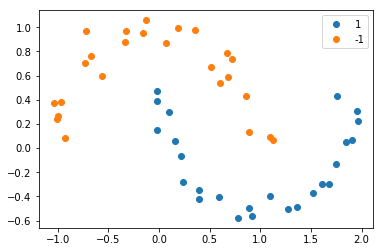

In [6]:
# training data
from sklearn import datasets

xdat,tdat = datasets.make_moons(n_samples = 50, noise = 0.1)
tdat = 2*tdat-1
plt.plot(xdat[:,0][tdat==1],xdat[:,1][tdat==1],"o",label="1")
plt.plot(xdat[:,0][tdat==-1],xdat[:,1][tdat==-1],"o",label="-1")
plt.legend()
# test data (for plotting)
xx = np.linspace(np.min(xdat[:,0]),np.max(xdat[:,0]),101)
yy = np.linspace(np.min(xdat[:,1]),np.max(xdat[:,1]),100)
Xtest = np.array([[x,y] for x in xx  for y in yy])
xxx,yyy = np.meshgrid(xx,yy)

plt.show()

First, we try linear SVM.

Learning time : 0.09700536727905273 seconds


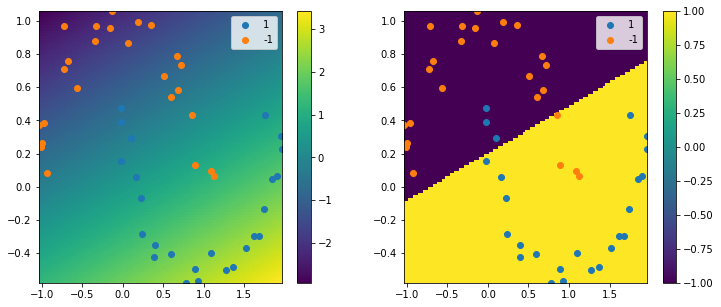

In [9]:
svc = SVC(C=10.0,kernel="linear",params={'s':0.1})
svc.fit(xdat,tdat,show_time=True)

pred_val = svc.decision_function(Xtest)
pred_val_2D = np.reshape(pred_val,(len(xx),len(yy))).T

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(xdat[:,0][tdat==1],xdat[:,1][tdat==1],"o",label="1")
plt.plot(xdat[:,0][tdat==-1],xdat[:,1][tdat==-1],"o",label="-1")
plt.legend()
plt.pcolormesh(xxx,yyy,pred_val_2D)
plt.colorbar()
plt.subplot(122)
plt.plot(xdat[:,0][tdat==1],xdat[:,1][tdat==1],"o",label="1")
plt.plot(xdat[:,0][tdat==-1],xdat[:,1][tdat==-1],"o",label="-1")
plt.legend()
plt.pcolormesh(xxx,yyy,np.sign(pred_val_2D))
plt.colorbar()
plt.show()

Next, we try Gaussian kernel.

Learning time : 0.05400276184082031 seconds


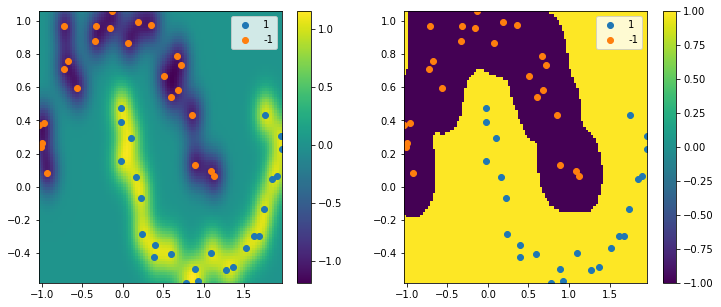

In [10]:
svc = SVC(C=10.0,kernel="gauss",params={'s':0.1})
svc.fit(xdat,tdat,show_time=True)

pred_val = svc.decision_function(Xtest)
pred_val_2D = np.reshape(pred_val,(len(xx),len(yy))).T

plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(xdat[:,0][tdat==1],xdat[:,1][tdat==1],"o",label="1")
plt.plot(xdat[:,0][tdat==-1],xdat[:,1][tdat==-1],"o",label="-1")
plt.legend()
plt.pcolormesh(xxx,yyy,pred_val_2D)
plt.colorbar()
plt.subplot(122)
plt.plot(xdat[:,0][tdat==1],xdat[:,1][tdat==1],"o",label="1")
plt.plot(xdat[:,0][tdat==-1],xdat[:,1][tdat==-1],"o",label="-1")
plt.legend()
plt.pcolormesh(xxx,yyy,np.sign(pred_val_2D))
plt.colorbar()
plt.show()

It can be seen that, thanks to kernel trick, we can handle such nonlinear decision boundary. 

Let us take a look at how hyperparameters $C$ and $s$ affect the result.

In [11]:
def plot_result(C,s,ax):
    
    svc = SVC(C=C,kernel="gauss",params={'s':s})
    svc.fit(X=xdat,t=tdat)
    pred_label = svc.predict(Xtest)
    pred_label_2D = np.reshape(pred_label,(len(xx),len(yy))).T
    
    ax.plot(xdat[:,0][tdat==1],xdat[:,1][tdat==1],"o",label="1")
    ax.plot(xdat[:,0][tdat==-1],xdat[:,1][tdat==-1],"o",label="-1")
    ax.legend()
    ax.pcolormesh(xxx,yyy,pred_label_2D)
    ax.set_title(f"C={C},s={s}")

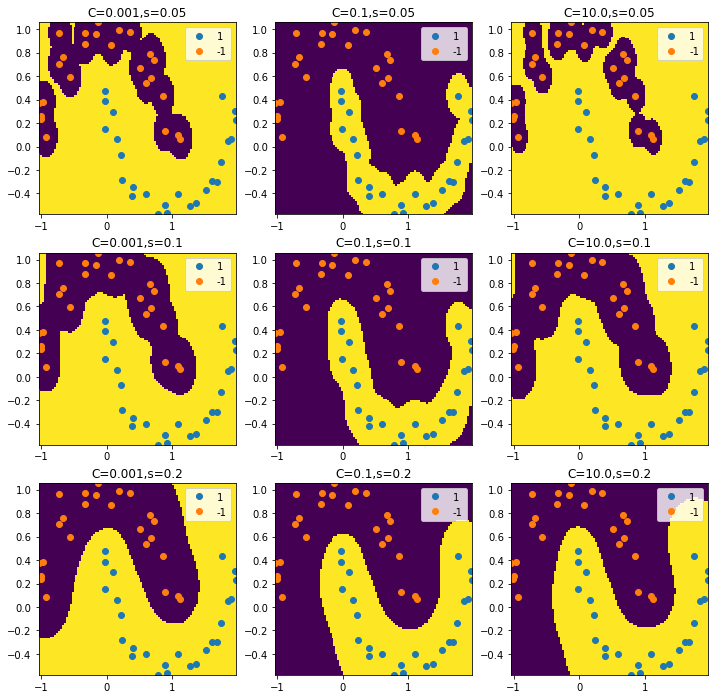

In [12]:
ss = [0.05, 0.1, 0.2]
CC = [0.001,0.1,10.0]

fig = plt.figure(figsize=(12,12))
for (cnts,s) in enumerate(ss):
    for (cntC,C) in enumerate(CC):
        ax = fig.add_subplot(len(ss),len(CC),cnts*len(CC)+cntC+1)
        plot_result(C,s,ax)
plt.show()

We can see that increasing $s$ makes the decision boundary smoother, as can be anticipated intuitively.